# Demonstration of MCMC non-linear regression with EMCEE and refnx

`refnx` is a package that can be used for non-linear regression (curvefitting). Here I demonstrate how it can be used to analyse Gaussian curve dataset, with Bayesian MCMC sampling of the posterior distributions of the parameters. This is a very robust way of estimating parameter uncertainties. I will also do the analysis with the `emcee` package for comparison

The first step is all the imports.

In [1]:
import numpy as np
import emcee
import corner
from scipy.optimize import leastsq
from refnx.analysis import CurveFitter
import refnx.analysis as ra
from matplotlib.pyplot import *
from lmfit import fit_report
%matplotlib inline
matplotlib.pyplot.rcParams['figure.figsize'] = (10.0, 6.0)
matplotlib.pyplot.rcParams['figure.dpi'] = 600

First step is to load some data in.

<Container object of 3 artists>

/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


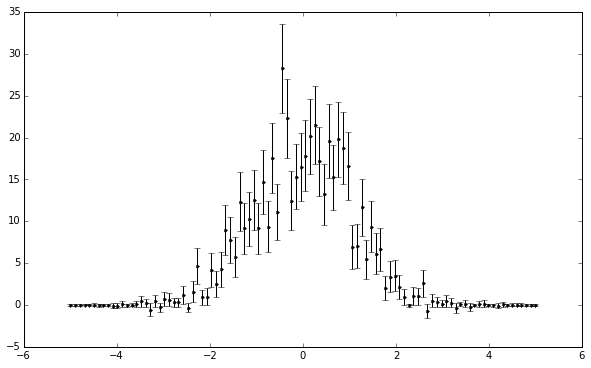

In [2]:
theoretical = np.loadtxt('gauss_data.txt')
xvals, yvals, evals = np.hsplit(theoretical, 3)
xvals = xvals.flatten()
yvals = yvals.flatten()
evals = evals.flatten()
errorbar(xvals, yvals, yerr=evals, fmt='.k')

Define the fit functions. The first type is what you would use for `refnx.analysis.CurveFitter`, the second is a function that you can use with `emcee`.

In [3]:
def gauss(x, p, *args):
    p0 = p.valuesdict()
    return p0['p0'] + p0['p1'] * np.exp(-((x - p0['p2']) / p0['p3'])**2)

def gauss2(x, p, *args):
    return p[0] + p[1] * np.exp(-((x - p[2]) / p[3])**2)

Set up initial parameter guesses and lower and upper bounds. The last step is to create an `lmfit.Parameters` instance for use with CurveFitter. The default parameter names created by `to_parameters` are 'p0', 'p1', ..., 'pn'.

In [4]:
p0 = np.array([0.1, 20., 0.1, 0.1])
bounds_varying = np.array([(-1, 1), (0, 30), (-5., 5.), (0.001, 2)])
params = ra.to_parameters(p0, bounds=bounds_varying)

## Analyse with emcee

To start with we'll do the analysis with the `emcee` package. Then we'll repeat the analysis with `refnx.analysis.CurveFitter`. 

The following functions have to be defined for `emcee`. The log-likelihood, the uniform log-prior and the overall log-posterior probability.

In [5]:
def residuals(theta):
    resid = (gauss2(xvals, theta) - yvals) / evals
    return resid
    
def lnlike(theta):
    # log likelihood
    return -0.5 * (np.sum(residuals(theta) ** 2))

def lnprior(theta):
    # uniform prior
    if (np.any(theta > bounds_varying[:, 1])
            or np.any(theta < bounds_varying[:, 0])):
        return -np.inf
    return 0

def lnpost(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

Lets fit the data with least squares first.

In [6]:
result = leastsq(residuals, p0, full_output=True)
best_fit = result[0]
best_errors = np.sqrt(np.diag(result[1]))
for mean, std in zip(best_fit, best_errors):
    print("{:<12g} +/-  {:<10g}".format(mean, std))

-0.00245995  +/-  0.0220328 
19.5301      +/-  1.12791   
-0.0828432   +/-  0.0447593 
1.24691      +/-  0.0411562 


Set up the walkers for `emcee`.

In [7]:
ndim, nwalkers = 4, 100
pos = np.array([p0 * (1 + 1e-2 * np.random.randn(ndim))
    for i in range(nwalkers)])

Run the `emcee` sampler

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost)
a = sampler.run_mcmc(pos, 1000)

Discard 100 burn in steps for each walker and flatten the chain.

In [9]:
chain = sampler.chain[:, 100:, :].reshape(-1, 4)

## Analyse with CurveFitter

Now we're going to do the analysis using a `refnx.analysis.CurveFitter` instance, it should be a lot simpler than the direct approach above. First setup the curvefitter.

In [10]:
mini = CurveFitter(gauss, xvals, yvals, params, edata=evals)

First of all do a least-squares fit, to get a starting point for the sampling.

In [11]:
res_leastsq = mini.fit()

Now do the MCMC sampling with CurveFitter instead. There are 100 walkers, we do 2000 steps on each walker. After the sampling discard the first 100 steps of each walker and take every 5th step

In [12]:
# note that we initialise the emcee sampling with the output of the leastsq fit.
res_sampling = mini.emcee(nwalkers=100, steps=2000, burn=100, thin=5, params=res_leastsq.params)

The following plot shows the posterior distributions for each parameter

/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


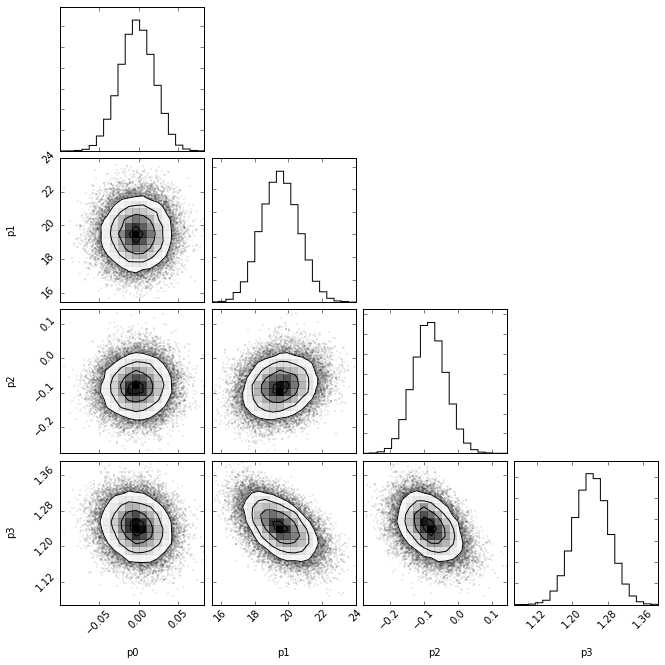

In [13]:
b=corner.corner(res_sampling.flatchain)

But what about the fits, are they good?

/Users/anz/miniconda3/envs/dev3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


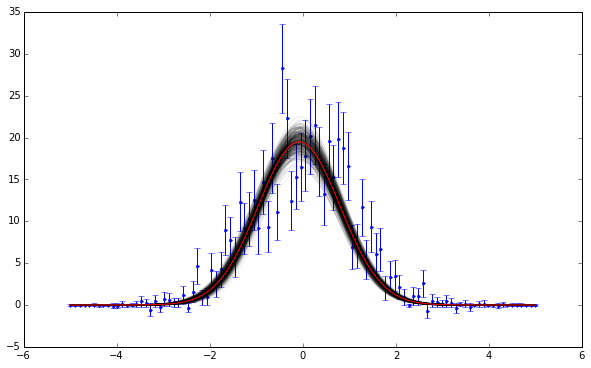

In [14]:
errorbar(xvals, yvals, yerr=evals, fmt=".")
for pars in np.asarray(res_sampling.flatchain)[np.random.randint(len(res_sampling.flatchain), size=500)]:
    plot(xvals, gauss2(xvals, pars), color="k", alpha=0.05)
plot(xvals, gauss(xvals, res_sampling.params), color='r')

The following fit parameters are obtained. Lets compare them to the least squares output.

In [15]:
print("Curvefitter.emcee")
print("-----------------")
print(fit_report(res_sampling.params))

print("\nleastsq")
print("-------")
print(fit_report(res_leastsq.params))

Curvefitter.emcee
-----------------
[[Variables]]
    p0:  -0.00207692 +/- 0.022150 (1066.52%) (init=-0.002460948)
    p1:   19.5089352 +/- 1.119985 (5.74%) (init= 19.52992)
    p2:  -0.08279230 +/- 0.048069 (58.06%) (init=-0.08284458)
    p3:   1.24338166 +/- 0.039255 (3.16%) (init= 1.246917)
[[Correlations]] (unreported correlations are <  0.100)
    C(p1, p3)                    = -0.513 
    C(p2, p3)                    = -0.382 
    C(p1, p2)                    =  0.193 
    C(p0, p3)                    = -0.146 

leastsq
-------
[[Variables]]
    p0:  -0.00246094 +/- 0.022032 (895.29%) (init= 0.1)
    p1:   19.5299161 +/- 1.127931 (5.78%) (init= 20)
    p2:  -0.08284457 +/- 0.044759 (54.03%) (init= 0.1)
    p3:   1.24691693 +/- 0.041156 (3.30%) (init= 0.1)
[[Correlations]] (unreported correlations are <  0.100)
    C(p1, p3)                    = -0.539 
    C(p2, p3)                    = -0.213 
    C(p0, p3)                    = -0.147 
    C(p1, p2)                    =  0.118 
